In [3]:
from scipy.io import loadmat
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

import polynomial as poly

%matplotlib inline

In [4]:
filelist = ["calcium_data/140708B_140811a_result", 
            "calcium_data/140909C_141112a_result", 
            "calcium_data/141006C_141121a_result",
            "calcium_data/150109A_150302a_result", 
            "calcium_data/151122A_160202a_result", 
            "calcium_data/151122B_160207a_result", 
            "calcium_data/160209A_160430a_result", 
            "calcium_data/160209B_160428a_result"]

In [12]:
filename = filelist[0]

f = h5py.File(filename+".hdf5", "r")
stims = np.unique(f['meta'][:,1])[1:]        #exclude zero
test_size = 0.33
svm_kernel = 'linear'
baseav = False

sc = []
for amp in stims:
    #average delta F
    #1s = 58 frames
    data = f['data']
    meta = f['meta']
    coefs = poly.fit_polynomial(filename, deg=9, exclude_mask=None)

    #baseline = np.mean(data[:,:,:58], axis=2).reshape(data.shape[0], data.shape[1], 1)
    #if baseav == True:
    #    baseline = np.mean(baseline, axis=0)

    #mn_dnd_chng = np.mean(data[:,:,58:116]-baseline, axis=2)

    present_mask = meta[:,1]==amp
    absent_mask = meta[:,1]==0

    trials_mask = np.logical_or(present_mask, absent_mask)

    y_score = np.transpose(coefs[:, trials_mask, :], axes=[1,2,0])
    y_score = y_score.reshape(y_score.shape[0], -1)
    #y_score = mn_dnd_chng[trials_mask, :]

    amp_mask = meta[:,1][trials_mask]==amp
    y_true = (amp_mask-0.5)*2

    #n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

    clf = RandomForestClassifier(n_estimators=50)
    scores = cross_val_score(clf, y_score, y_true.reshape(y_true.shape[0]), cv=10)
    sc.append(scores)

In [13]:
for k, scores in enumerate(sc):
    print("For stimApm {0: .2f}: accuracy: {1: .2f} (+/- {2: .2f})".format(stims[k], np.mean(scores), 2*np.std(scores)))

For stimApm  0.50: accuracy:  0.50 (+/-  0.18)
For stimApm  1.00: accuracy:  0.61 (+/-  0.24)
For stimApm  1.50: accuracy:  0.65 (+/-  0.39)
For stimApm  2.00: accuracy:  0.75 (+/-  0.18)
For stimApm  2.50: accuracy:  0.83 (+/-  0.32)
For stimApm  3.00: accuracy:  0.87 (+/-  0.28)


<Container object of 3 artists>

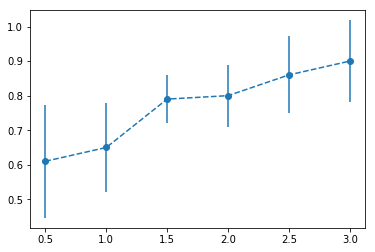

In [24]:
sc = np.array(sc)
means = np.mean(sc, axis=1)
std = np.std(sc, axis=1)

plt.errorbar(stims, means, yerr=std, fmt='--o')

In [19]:
filename = filelist[1]

f = h5py.File(filename+".hdf5", "r")
stims = np.unique(f['meta'][:,1])[1:]        #exclude zero
test_size = 0.33
svm_kernel = 'linear'
baseav = False

sc = []
bals = []
ns = []
for amp in stims:
    #average delta F
    #1s = 58 frames
    data = f['data']
    meta = f['meta']

    baseline = np.mean(data[:,:,:58], axis=2).reshape(data.shape[0], data.shape[1], 1)
    if baseav == True:
        baseline = np.mean(baseline, axis=0)

    mn_dnd_chng = np.mean(data[:,:,58:116]-baseline, axis=2)

    present_mask = meta[:,1]==amp
    #absent_mask = meta[:,1]==0

    #trials_mask = np.logical_or(present_mask, absent_mask)
    trials_mask = present_mask
    
    y_score = mn_dnd_chng[trials_mask, :]

    hit_mask = meta[:, 2]==1
    
    #print(data[trials_mask])
    
    end_mask = hit_mask[trials_mask]
    y_true = (end_mask-0.5)*2
    
    balance = np.sum(end_mask)/end_mask.shape[0]
    n_y = end_mask.shape[0]
    
    bals.append(balance)
    ns.append(n_y)

    n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

    clf = RandomForestClassifier(n_estimators=50, class_weight='balanced')
    scores = cross_val_score(clf, y_score, y_true.reshape(y_true.shape[0]), cv=4)
    sc.append(scores)

In [20]:
for k, scores in enumerate(sc):
    print("For stimApm {0: .2f}: accuracy: {1: .2f} (+/- {2: .2f})".format(stims[k], np.mean(scores), 2*np.std(scores)))

For stimApm  0.33: accuracy:  0.94 (+/-  0.14)
For stimApm  0.67: accuracy:  0.91 (+/-  0.01)
For stimApm  1.00: accuracy:  0.85 (+/-  0.13)
For stimApm  1.33: accuracy:  0.71 (+/-  0.47)
For stimApm  1.67: accuracy:  0.89 (+/-  0.07)
For stimApm  2.00: accuracy:  0.87 (+/-  0.07)


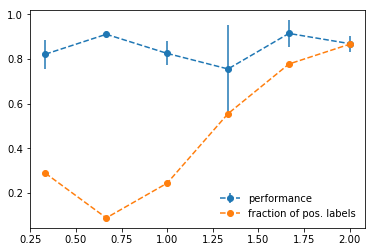

In [17]:
sc = np.array(sc)
means = np.mean(sc, axis=1)
std = np.std(sc, axis=1)

plt.errorbar(stims, means, yerr=std, fmt='--o', label='performance')
plt.errorbar(stims, bals, fmt='--o', label='fraction of pos. labels')
plt.legend(frameon=False)